<a href="https://colab.research.google.com/github/alexchilton/CAS_Project/blob/main/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import libraries

In [ ]:
%pip install tqdn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import LearningRateScheduler

# 2. Paths and constants

In [3]:
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [4]:
# For Colab only_move to function file directory, load and go back to content /drive
%cd /content/drive/MyDrive/CAS_AML/function_files
import functions_m1_m2
%cd /content/drive

/content/drive/MyDrive/CAS_AML/function_files
/content/drive


In [79]:
DIR_TRAIN = '/content/drive/MyDrive/CAS_AML/datasets/fruits_clean/train'
DIR_TEST = '/content/drive/MyDrive/CAS_AML/datasets/fruits_clean/test'
DIR_VALIDATION = '/content/drive/MyDrive/CAS_AML/datasets/fruits_clean/validation'
OUTPUT_DIR = '/content/drive/MyDrive/CAS_AML/outputs'


MODEL_LOCATION = '/content/drive/MyDrive/CAS_AML/models'

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 3. Dataset preparation

In [80]:
train_dir = DIR_TRAIN
validation_dir = DIR_VALIDATION

BATCH_SIZE = 32
IMG_SIZE = (299, 299)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2362 files belonging to 33 classes.


In [81]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 302 files belonging to 33 classes.


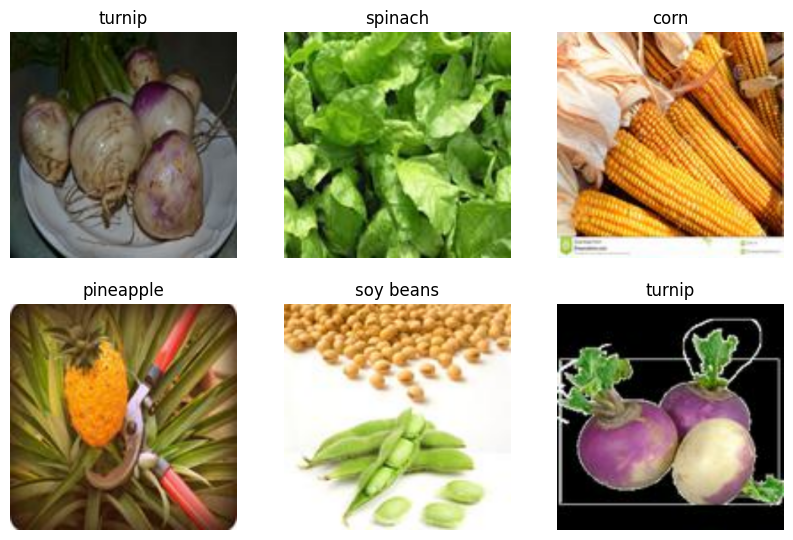

In [82]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [83]:
# Create test dataset out of the train
test_batches = tf.data.experimental.cardinality(train_dataset)
test_dataset = train_dataset.take(test_batches // 5)
train_dataset = train_dataset.skip(test_batches // 5)


In [84]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of train batches: 60
Number of test batches: 14


In [85]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


## 3.1 Data augmentation for better generalization

In [86]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


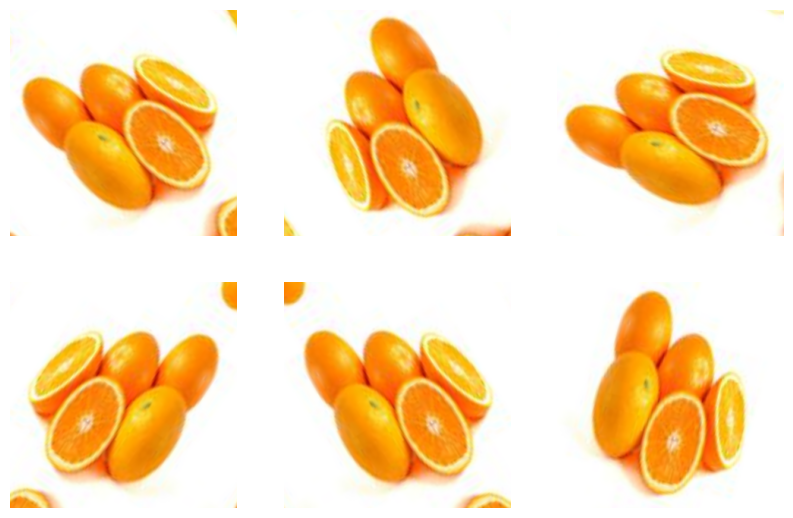

In [87]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


# 4. Transfer learning

## 4.1 ResNet50

https://keras.io/api/applications/resnet/

In [38]:
from tensorflow.keras.applications import resnet50

### 4.1.1 Data preprocessing

In [39]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

### 4.1.2 Base model

In [40]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [41]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


### 4.1.3 Feature extraction

When unfreezing a model that contains BatchNormalization layers in order to do fine-tuning, the BatchNormalization layers should be kept in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [42]:
base_model.trainable = False

In [43]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

### 4.1.4 Top layer: classifier

In [44]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [45]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 33)


In [46]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [47]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 224, 224, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 33)             │         67,617 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,655,329 (90.24 MB)

 Trainable params: 67,617 (264.13 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

### 4.1.5 Model and parameter summary

In [48]:
len(model.trainable_variables)

2

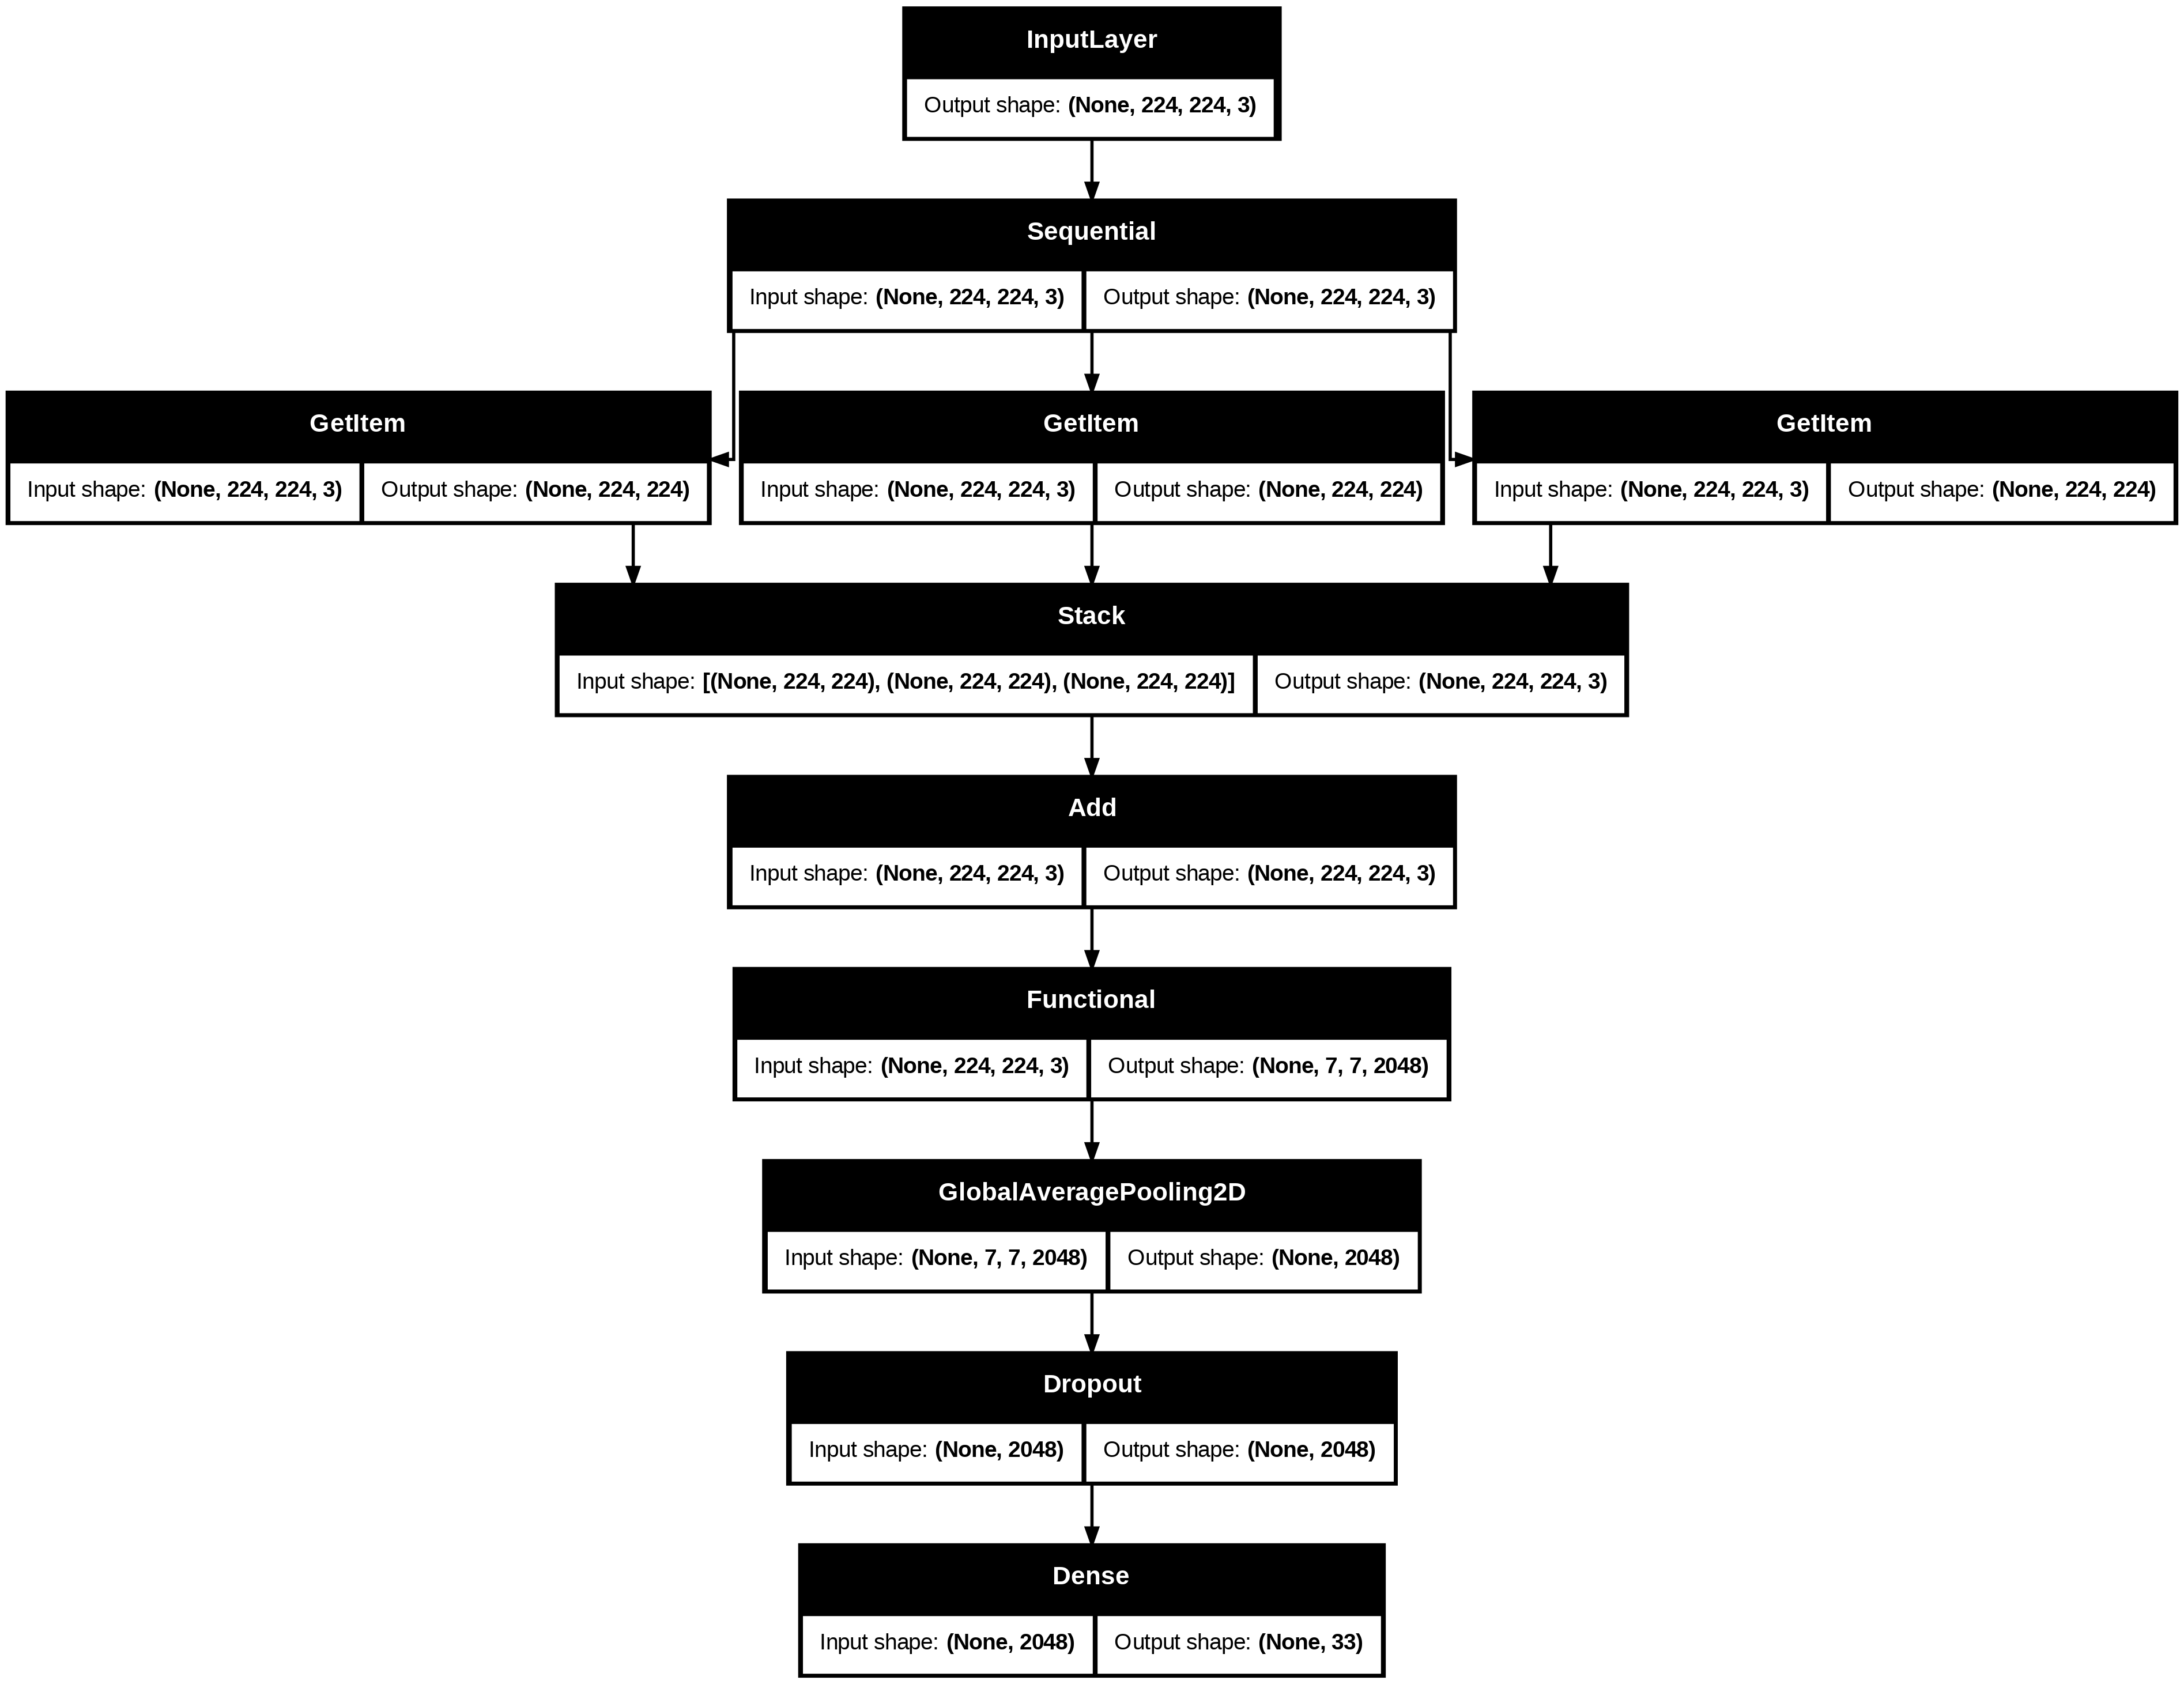

In [49]:
tf.keras.utils.plot_model(model, to_file='/content/model.png', show_shapes=True)
from IPython.display import Image
Image('/content/model.png')

### 4.1.6 Training

In [50]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])


In [51]:
initial_epochs = 15

loss0, accuracy0 = model.evaluate(validation_dataset)

10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 977ms/step - accuracy: 0.0537 - loss: 3.9949


In [52]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.00
initial accuracy: 0.06


In [53]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 48s 689ms/step - accuracy: 0.0566 - loss: 3.9163 - val_accuracy: 0.2185 - val_loss: 2.8968
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.1869 - loss: 3.0273 - val_accuracy: 0.4305 - val_loss: 2.2126
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.3579 - loss: 2.3654 - val_accuracy: 0.5861 - val_loss: 1.7269
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.4511 - loss: 1.9889 - val_accuracy: 0.6887 - val_loss: 1.3918
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5682 - loss: 1.6611 - val_accuracy: 0.7450 - val_loss: 1.1441
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.6383 - loss: 1.4038 - val_accuracy: 0.8311 - val_loss: 0.9608
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6764 - loss: 1.2817 - val_accuracy: 0.8775 - val_loss: 0.8281
Epoch 8/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.7351 - loss: 1.1293 - val_accuracy: 0.8808 -

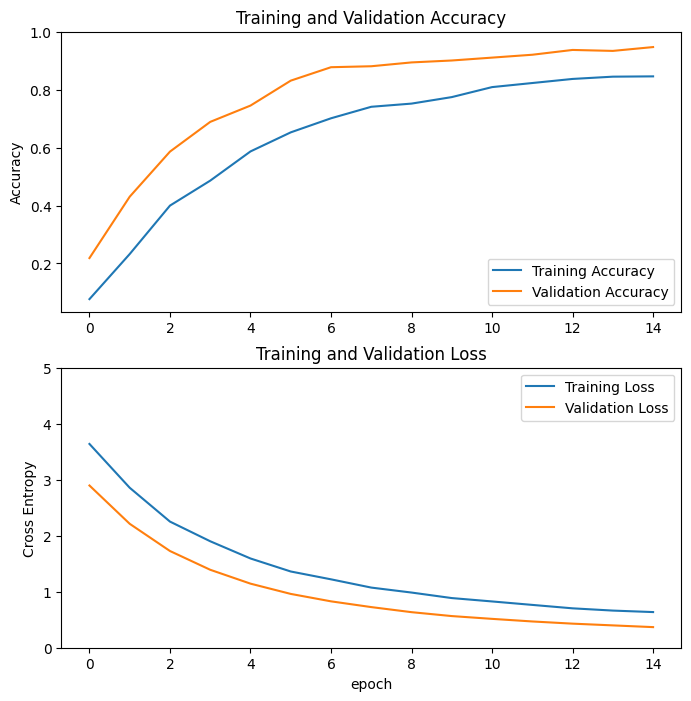

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


### 4.1.7 Fine Tuning

In [55]:
base_model.trainable = True

In [56]:
print("Number of layers in the base model: ", len(base_model.layers))

# Update basing on the model in use and its structure
fine_tune_at = 143

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


In [57]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [58]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 224, 224, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 33)             │         67,617 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,655,329 (90.24 MB)

 Trainable params: 15,043,617 (57.39 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

In [59]:
len(model.trainable_variables)

42

In [60]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 16/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.7844 - loss: 0.8375 - val_accuracy: 0.9570 - val_loss: 0.2700
Epoch 17/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8508 - loss: 0.6278 - val_accuracy: 0.9570 - val_loss: 0.2165
Epoch 18/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8601 - loss: 0.5606 - val_accuracy: 0.9669 - val_loss: 0.1794
Epoch 19/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.8957 - loss: 0.4566 - val_accuracy: 0.9801 - val_loss: 0.1509
Epoch 20/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9020 - loss: 0.4285 - val_accuracy: 0.9801 - val_loss: 0.1299
Epoch 21/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9026 - loss: 0.3961 - val_accuracy: 0.9801 - val_loss: 0.1158
Epoch 22/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9187 - loss: 0.3139 - val_accuracy: 0.9801 - val_loss: 0.1047
Epoch 23/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9327 - loss: 0.2807 - val_accuracy: 0

In [61]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

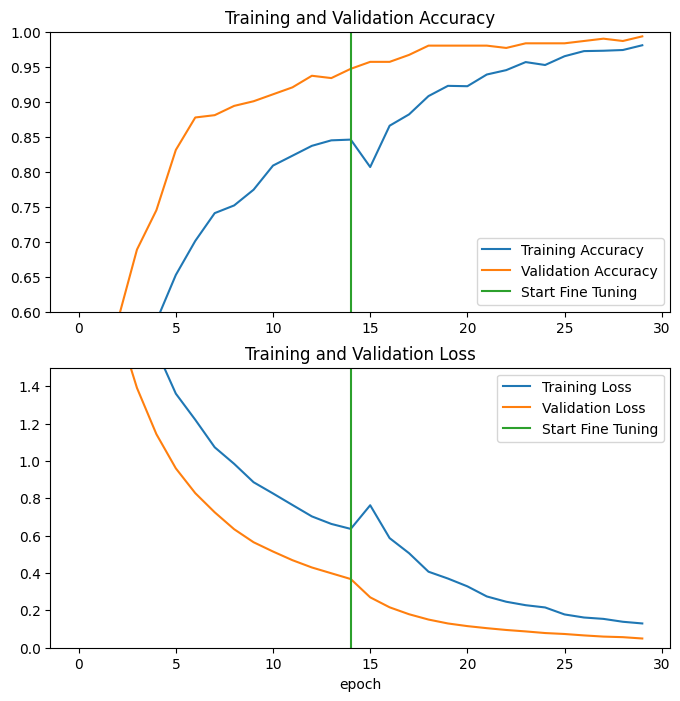

In [62]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 4.1.8 Model evaluation and prediction

In [63]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9647 - loss: 0.1451
Test accuracy : 0.9620535969734192


Predictions:
 [ 8 13  8 31 28  3 26 32 31 19 12 32  8 15 14  1 24  7 22 31 19 24 28 21
 28 20 32 20 10 23 10 28]
Labels:
 [ 8 13  8 31 28  3 26 32 31 19 12 32  8 15 14  1 24  7 22 31 19 24 17 21
  6 20 32 20 10 23 10 28]


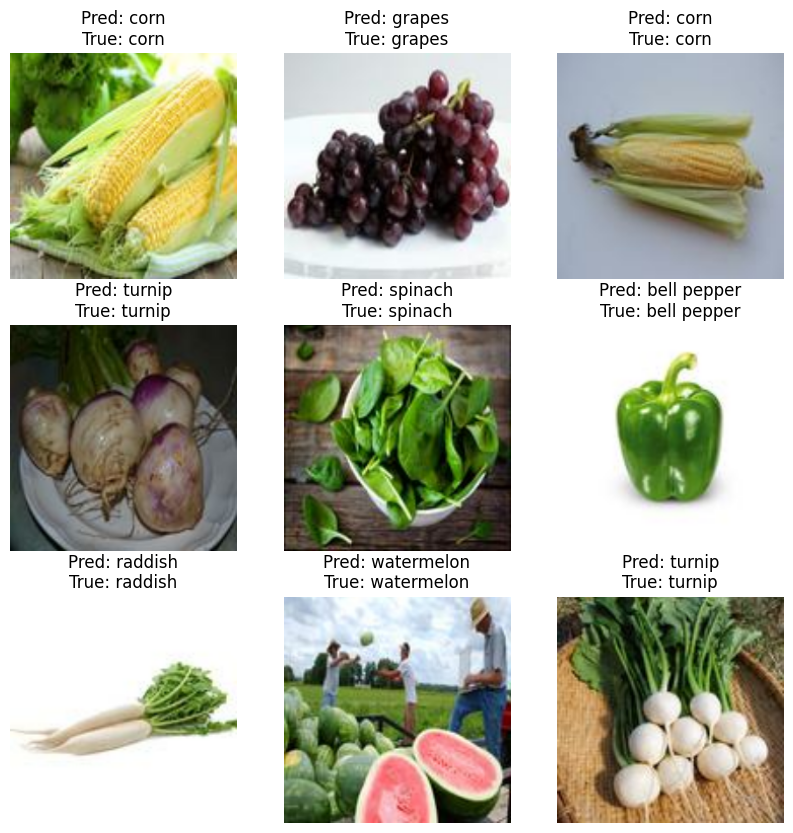

In [64]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)  # Shape: (batch_size, num_classes)

predicted_classes = np.argmax(predictions, axis=-1)  # Shape: (batch_size,)


print('Predictions:\n', predicted_classes)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(min(9, len(image_batch))):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"Pred: {class_names[predicted_classes[i]]}\nTrue: {class_names[label_batch[i]]}")
    plt.axis("off")

plt.show()


### 4.1.9 Save the model

In [65]:
model.save(os.path.join(MODEL_LOCATION, 'resnet_model.keras'))

## 5.2 Xception

Documentation:  
https://keras.io/api/applications/xception/




In [88]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input

### 5.1.1 Data preprocessing

In [89]:
preprocess_input = tf.keras.applications.xception.preprocess_input

### 5.1.2 Base model

In [90]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [91]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 10, 10, 2048)


### 5.1.3 Feature extraction

When unfreezing a model that contains BatchNormalization layers in order to do fine-tuning, the BatchNormalization layers should be kept in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [92]:
base_model.trainable = False

In [93]:
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

### 5.1.4 Top layer: classifier

In [94]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [95]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 33)


In [96]:
inputs = tf.keras.Input(shape=(299, 299, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [97]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 33)                  │          67,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,929,097 (79.84 MB)

 Trainable params: 67,617 (264.13 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

### 5.1.5 Model and parameter summary

In [98]:
len(model.trainable_variables)

2

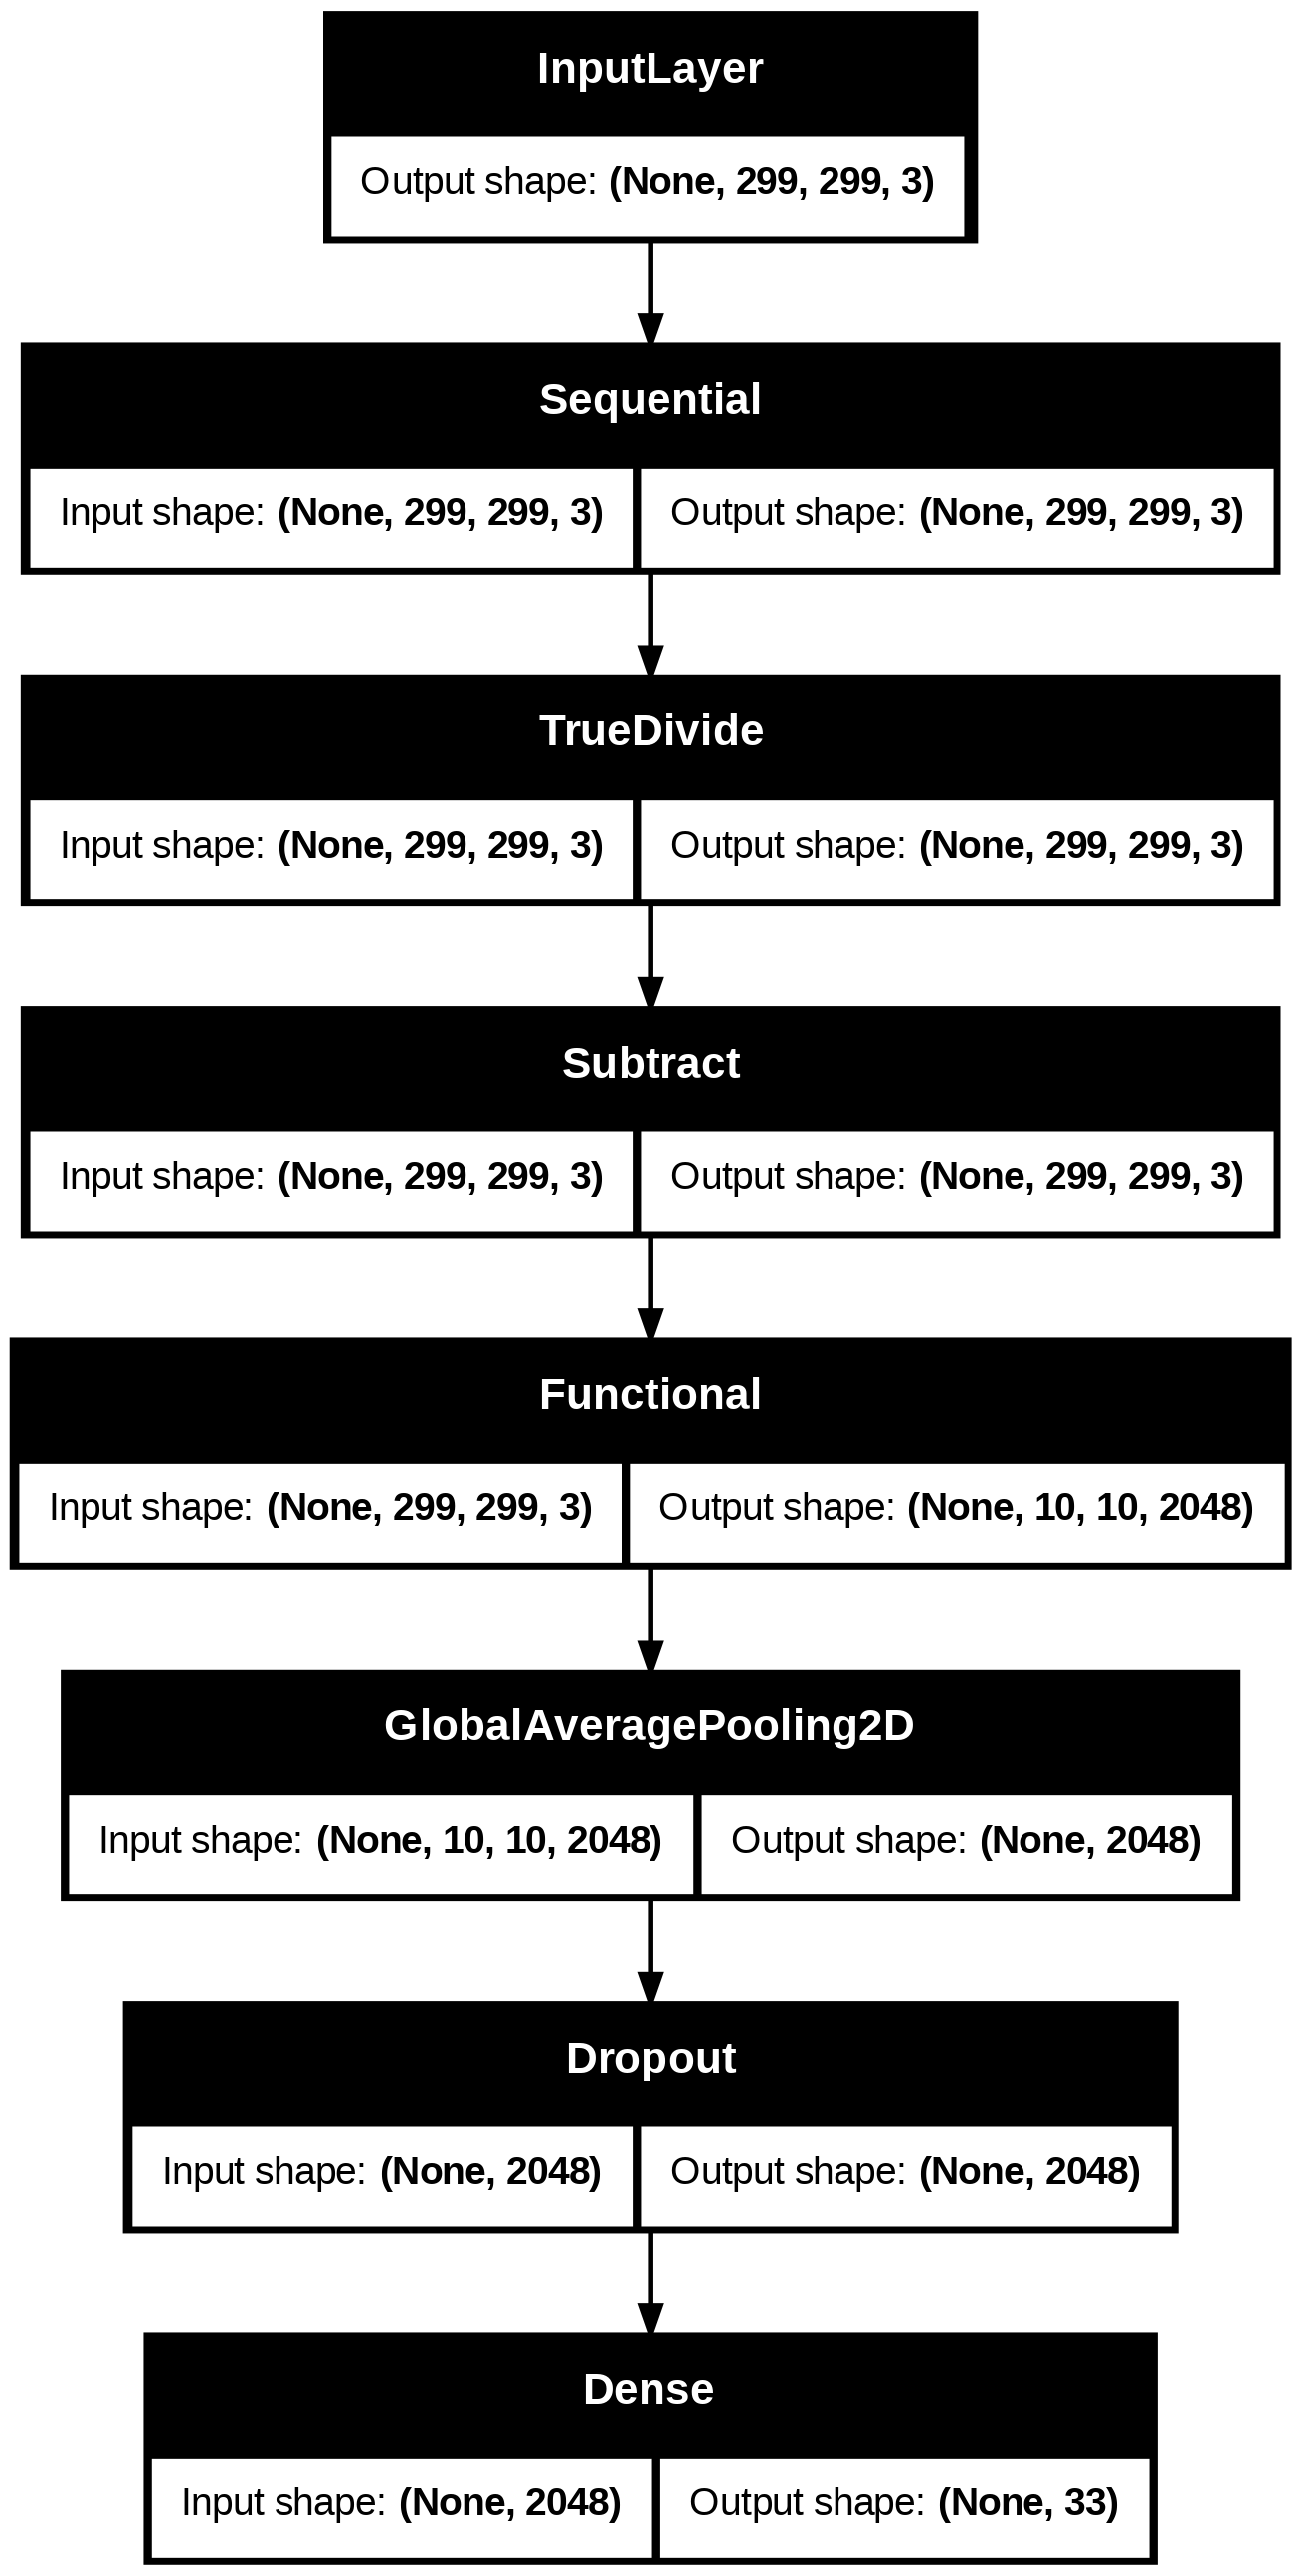

In [99]:
tf.keras.utils.plot_model(model, to_file='/content/model_xception.png', show_shapes=True)
from IPython.display import Image
Image('/content/model_xception.png')

### 5.1.6 Training

In [100]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])


In [101]:
initial_epochs = 15

loss0, accuracy0 = model.evaluate(validation_dataset)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.0542 - loss: 3.4742


In [102]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.48
initial accuracy: 0.04


In [103]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.0770 - loss: 3.4349 - val_accuracy: 0.3013 - val_loss: 3.1595
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.2592 - loss: 3.1222 - val_accuracy: 0.4570 - val_loss: 2.8789
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.4113 - loss: 2.8869 - val_accuracy: 0.5993 - val_loss: 2.6217
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.5120 - loss: 2.6357 - val_accuracy: 0.6689 - val_loss: 2.3937
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.5824 - loss: 2.4485 - val_accuracy: 0.7285 - val_loss: 2.1861
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.6563 - loss: 2.2302 - val_accuracy: 0.7517 - val_loss: 2.0014
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.6633 - loss: 2.1089 - val_accuracy: 0.7815 - val_loss: 1.8390
Epoch 8/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.7157 - loss: 1.9304 - val_accuracy: 0.7947 - v

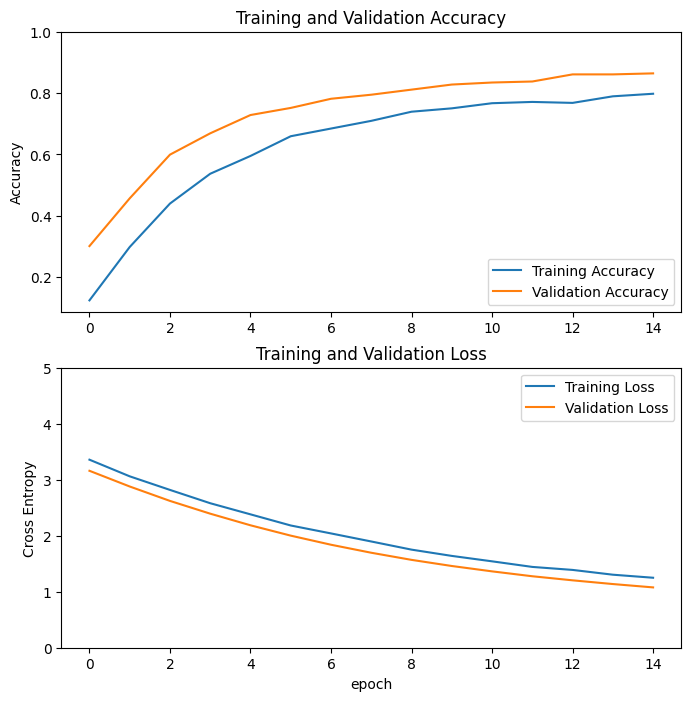

In [104]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


### 5.1.7 Fine Tuning

In [105]:
base_model.trainable = True

In [107]:
print("Number of layers in the base model: ", len(base_model.layers))

# Update basing on the model in use and its structure
fine_tune_at = 81  # Beginning of the exit flow

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  132


In [108]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [109]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 33)                  │          67,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,929,097 (79.84 MB)

 Trainable params: 8,469,977 (32.31 MB)

 Non-trainable params: 12,459,120 (47.53 MB)

In [110]:
len(model.trainable_variables)

33

In [112]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 16/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.8892 - loss: 0.5256 - val_accuracy: 0.9470 - val_loss: 0.2685
Epoch 17/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.8914 - loss: 0.4907 - val_accuracy: 0.9470 - val_loss: 0.2581
Epoch 18/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.8871 - loss: 0.4563 - val_accuracy: 0.9503 - val_loss: 0.2462
Epoch 19/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.8923 - loss: 0.4390 - val_accuracy: 0.9503 - val_loss: 0.2336
Epoch 20/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9160 - loss: 0.4224 - val_accuracy: 0.9503 - val_loss: 0.2209
Epoch 21/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9130 - loss: 0.4155 - val_accuracy: 0.9503 - val_loss: 0.2105
Epoch 22/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.8969 - loss: 0.4327 - val_accuracy: 0.9536 - val_loss: 0.2127
Epoch 23/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9091 - loss: 0.3840 - val_accuracy: 0.

In [113]:
new_epochs = 10
final_epochs= total_epochs + new_epochs

history_fine = model.fit(train_dataset,
                         epochs=final_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 16/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9280 - loss: 0.3267 - val_accuracy: 0.9669 - val_loss: 0.1508
Epoch 17/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9389 - loss: 0.2893 - val_accuracy: 0.9603 - val_loss: 0.1445
Epoch 18/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9440 - loss: 0.2747 - val_accuracy: 0.9669 - val_loss: 0.1386
Epoch 19/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9467 - loss: 0.2625 - val_accuracy: 0.9702 - val_loss: 0.1334
Epoch 20/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9425 - loss: 0.2690 - val_accuracy: 0.9636 - val_loss: 0.1301
Epoch 21/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9506 - loss: 0.2474 - val_accuracy: 0.9669 - val_loss: 0.1268
Epoch 22/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9433 - loss: 0.2537 - val_accuracy: 0.9702 - val_loss: 0.1261
Epoch 23/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9508 - loss: 0.2349 - val_accuracy: 0.

In [114]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

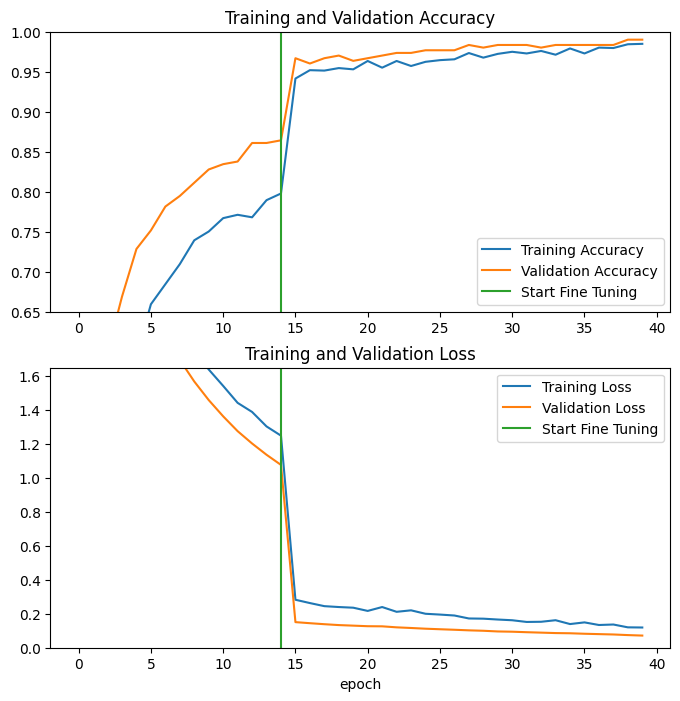

In [115]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.65, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.65])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 5.1.8 Model evaluation and prediction

In [116]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9437 - loss: 0.1947
Test accuracy : 0.9508928656578064


Predictions:
 [22 17 24 11  9  1 31 21 27  1 28 26 16  8  8  8 15  4 21 15 27  9  4 25
 31  9 17 21  8  9  0  6]
Labels:
 [22 17 24 11  9  1 31 21 27  1 28 26 18  8  8  8 15  4 21 15 27  9  4 25
 31  9 17 21  8  9  0  6]


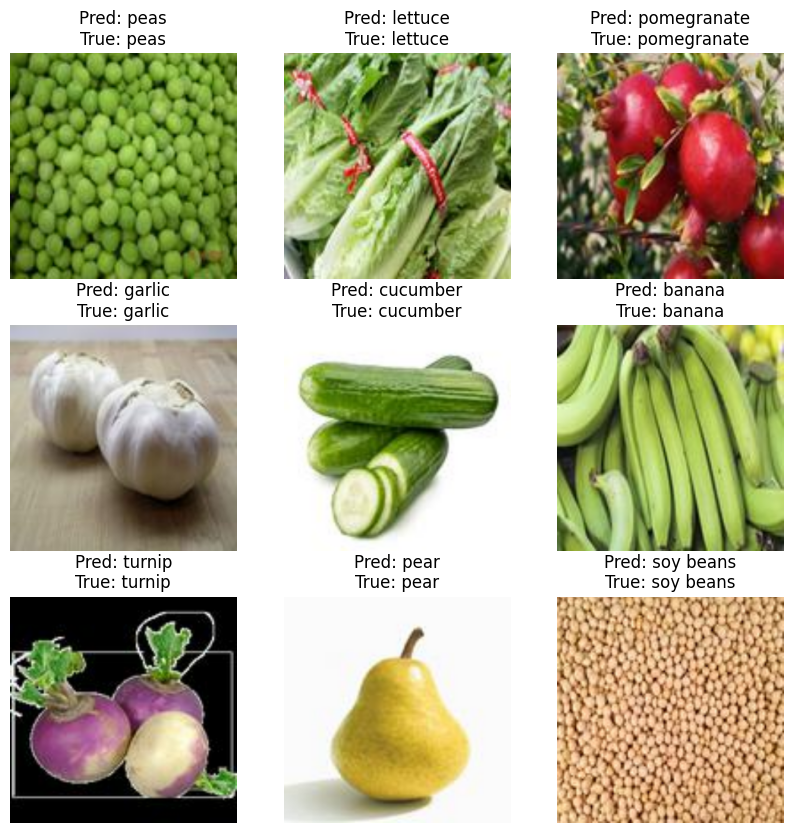

In [117]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)  # Shape: (batch_size, num_classes)

predicted_classes = np.argmax(predictions, axis=-1)  # Shape: (batch_size,)


print('Predictions:\n', predicted_classes)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(min(9, len(image_batch))):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"Pred: {class_names[predicted_classes[i]]}\nTrue: {class_names[label_batch[i]]}")
    plt.axis("off")

plt.show()


### 5.1.9 Save the model

In [118]:
model.save(os.path.join(MODEL_LOCATION, 'xception_model.keras'))